# Boosting to predict `Salary` in `Hitters` dataset

## Preparing the data

In [116]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
hitters = pd.read_csv('../../datasets/Hitters.csv')
hitters = hitters.rename(columns={'Unnamed: 0': 'Name'})
hitters.head()

,Name,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [3]:
hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
Name         322 non-null object
AtBat        322 non-null int64
Hits         322 non-null int64
HmRun        322 non-null int64
Runs         322 non-null int64
RBI          322 non-null int64
Walks        322 non-null int64
Years        322 non-null int64
CAtBat       322 non-null int64
CHits        322 non-null int64
CHmRun       322 non-null int64
CRuns        322 non-null int64
CRBI         322 non-null int64
CWalks       322 non-null int64
League       322 non-null object
Division     322 non-null object
PutOuts      322 non-null int64
Assists      322 non-null int64
Errors       322 non-null int64
Salary       263 non-null float64
NewLeague    322 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 52.9+ KB


In [4]:
hitters = pd.concat([hitters['Name'],
                     pd.get_dummies(hitters.drop(columns=['Name']), drop_first=True)], axis=1)
hitters.head()

,Name,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,446,33,20,NaN,0,0,0
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,632,43,10,475.0,1,1,1
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,880,82,14,480.0,0,1,0
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,200,11,3,500.0,1,0,1
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,805,40,4,91.5,1,0,1


## a. Remove observations with missing `Salary` and log-transform `Salary`

In [9]:
hitters = hitters[hitters['Salary'].notna()]
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Name           263 non-null object
AtBat          263 non-null int64
Hits           263 non-null int64
HmRun          263 non-null int64
Runs           263 non-null int64
RBI            263 non-null int64
Walks          263 non-null int64
Years          263 non-null int64
CAtBat         263 non-null int64
CHits          263 non-null int64
CHmRun         263 non-null int64
CRuns          263 non-null int64
CRBI           263 non-null int64
CWalks         263 non-null int64
PutOuts        263 non-null int64
Assists        263 non-null int64
Errors         263 non-null int64
Salary         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(1), int64(16), object(1), uint8(3)
memory usage: 39.8+ KB


In [10]:
hitters.loc[:, 'Salary'] = np.log(hitters['Salary'])

## b. Train test split

In [11]:
from sklearn.model_selection import train_test_split

X, y = hitters.drop(columns=['Name', 'Salary']), hitters['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200)

## c. Boosting on training set

We used this [article](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/) to suggest customary values of the boosting parameter $\lambda$ (the "learning rate")

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
boost_tree = GradientBoostingRegressor(n_estimators=1000)
boost_tree_search = GridSearchCV(estimator=boost_tree,
                                 param_grid=params,
                                 cv=10,
                                 scoring='neg_mean_squared_error')
%timeit -n1 -r1 boost_tree_search.fit(X_train, y_train)

19.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
boost_tree_search.best_params_

{'learning_rate': 0.01}

In [15]:
-boost_tree_search.best_score_

0.0066770413811597165

## d. Plotting train error, cv test error estimate, and test error

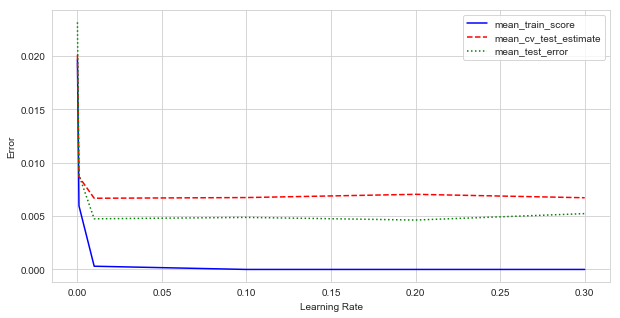

In [65]:
from sklearn.metrics import mean_squared_error

boost_tree_search_df = pd.DataFrame(boost_tree_search.cv_results_)

plt.figure(figsize=(10, 5))
x = boost_tree_search_df['param_learning_rate']
y = -boost_tree_search_df['mean_train_score']
plt.plot(x, y, '-b')

y = -boost_tree_search_df['mean_test_score']
plt.plot(x, y, '--r', label='mean_cv_test_estimate')

y = []
for rate in params['learning_rate']:
    boost_tree = GradientBoostingRegressor(n_estimators=1000, learning_rate=rate).fit(X_train, y_train)
    y += [mean_squared_error(y_test, boost_tree.predict(X_test))]
plt.plot(x, y, ':g', label='mean_test_error')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.legend()

## e.  Comparing errors with OLS, Lasso, and Ridge Regression models

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score

# df for comparison results
comp_df = pd.DataFrame(index=['OLS', 'Ridge', 'Boosted Tree'], columns=['mse_train', 'cv_mse_test', 'mse_test'])

# OLS linear regression errors
linreg = LinearRegression()
linreg.fit(X_train, y_train)
comp_df.at['OLS', 'mse_train'] = mean_squared_error(linreg.predict(X_train), y_train)
comp_df.at['OLS', 'cv_mse_test'] = np.mean(-cross_val_score(linreg, X_train, y_train, cv=10, 
                                                            scoring='neg_mean_squared_error'))
comp_df.at['OLS', 'mse_test'] = mean_squared_error(linreg.predict(X_test), y_test)

# Lasso Regression errors
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso(max_iter=10000)
lasso_search = GridSearchCV(lasso, param_grid=params, cv=10, scoring='neg_mean_squared_error').fit(X_train, y_train)
lasso_best = lasso_search.best_estimator_
comp_df.at['Lasso', 'mse_train'] = mean_squared_error(lasso_best.predict(X_train), y_train)
comp_df.at['Lasso', 'cv_mse_test'] = np.mean(-cross_val_score(lasso_best, X_train, y_train, cv=10, 
                                                            scoring='neg_mean_squared_error'))
comp_df.at['Lasso', 'mse_test'] = mean_squared_error(lasso_best.predict(X_test), y_test)

# Ridge Regression errors
ridge = Ridge(max_iter=10000)
ridge_search = GridSearchCV(ridge, param_grid=params, cv=10, scoring='neg_mean_squared_error').fit(X_train, y_train)
ridge_best = ridge_search.best_estimator_
comp_df.at['Ridge', 'mse_train'] = mean_squared_error(ridge_best.predict(X_train), y_train)
comp_df.at['Ridge', 'cv_mse_test'] = np.mean(-cross_val_score(ridge_best, X_train, y_train, cv=10, 
                                                            scoring='neg_mean_squared_error'))
comp_df.at['Ridge', 'mse_test'] = mean_squared_error(ridge_best.predict(X_test), y_test)

# Boosted Tree errors
boost_tree_best = boost_tree_search.best_estimator_
comp_df.at['Boosted Tree', 'mse_train'] = mean_squared_error(boost_tree_best.predict(X_train), y_train)
comp_df.at['Boosted Tree', 'cv_mse_test'] = np.mean(-cross_val_score(boost_tree_best, X_train, y_train, cv=10, 
                                                            scoring='neg_mean_squared_error'))
comp_df.at['Boosted Tree', 'mse_test'] = mean_squared_error(boost_tree_best.predict(X_test), y_test)

Here's the model comparison in order of increasing training error

In [85]:
comp_df.sort_values(by='mse_train')

,mse_train,cv_mse_test,mse_test
Boosted Tree,0.00037481,0.00662225,0.00473355
OLS,0.0113734,0.0148324,0.0100858
Lasso,0.0114361,0.014843,0.00972244
Ridge,0.0114704,0.0146984,0.00965864


And cv test error estimate

In [84]:
comp_df.sort_values(by='cv_mse_test')

,mse_train,cv_mse_test,mse_test
Boosted Tree,0.00037481,0.00662225,0.00473355
Ridge,0.0114704,0.0146984,0.00965864
OLS,0.0113734,0.0148324,0.0100858
Lasso,0.0114361,0.014843,0.00972244


And finally test error

In [86]:
comp_df.sort_values(by='mse_test')

,mse_train,cv_mse_test,mse_test
Boosted Tree,0.00037481,0.00662225,0.00473355
Ridge,0.0114704,0.0146984,0.00965864
Lasso,0.0114361,0.014843,0.00972244
OLS,0.0113734,0.0148324,0.0100858


The boosted tree is a clear winner in all 3 cases

## f. Which variables are the most important in the boosted tree model?

In [92]:
feat_imp_df = pd.DataFrame({'Feature Importance': boost_tree_best.feature_importances_}, 
                        index=X.columns)
feat_imp_df.sort_values(by='Feature Importance', ascending=False)

,Feature Importance
CAtBat,0.441317
CHits,0.152543
CRuns,0.069480
Hits,0.049296
CWalks,0.048265
CRBI,0.035715
CHmRun,0.025762
AtBat,0.025063
Walks,0.024959
Years,0.024882


## Bagged tree

In [110]:
from sklearn.ensemble import BaggingRegressor

# Bagged Tree randomized CV search for rough hyperparameter tuning
params = {'n_estimators': np.arange(1, 100, 10)}
bag_tree = BaggingRegressor()
bag_tree_search = GridSearchCV(estimator=bag_tree, param_grid=params, cv=10,
                               scoring='neg_mean_squared_error')
bag_tree_best = bag_tree_search.fit(X_train, y_train).best_estimator_

%timeit -n1 -r1 bag_tree_search.fit(X_train, y_train)

7.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [113]:
bag_tree_search.best_params_

{'n_estimators': 21}

In [115]:
bag_tree_best = bag_tree_search.best_estimator_

# Bagged Tree errors
comp_df.at['Bagged Tree', 'mse_train'] = mean_squared_error(bag_tree_best.predict(X_train), y_train)
comp_df.at['Bagged Tree', 'cv_mse_test'] = np.mean(-cross_val_score(bag_tree_best, X_train, y_train, cv=10, 
                                                            scoring='neg_mean_squared_error'))
comp_df.at['Bagged Tree', 'mse_test'] = mean_squared_error(bag_tree_best.predict(X_test), y_test)

comp_df.sort_values(by='mse_test')

,mse_train,cv_mse_test,mse_test
Bagged Tree,0.00100862,0.0064751,0.0045024
Boosted Tree,0.00037481,0.00662225,0.00473355
Ridge,0.0114704,0.0146984,0.00965864
Lasso,0.0114361,0.014843,0.00972244
OLS,0.0113734,0.0148324,0.0100858
